In [36]:
import os

# Limit BLAS thread pools BEFORE importing numpy / implicit
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [37]:
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares

from sklearn.model_selection import train_test_split

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

INTERACTIONS_PATH = DATA_PROCESSED / "interactions.parquet"
TRACK_META_PATH   = DATA_PROCESSED / "track_metadata.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("INTERACTIONS_PATH:", INTERACTIONS_PATH)
print("TRACK_META_PATH:", TRACK_META_PATH)



PROJECT_ROOT: C:\Users\Kiera\Music_Recommender
INTERACTIONS_PATH: C:\Users\Kiera\Music_Recommender\data\processed\interactions.parquet
TRACK_META_PATH: C:\Users\Kiera\Music_Recommender\data\processed\track_metadata.csv


In [38]:
interactions = pd.read_parquet(INTERACTIONS_PATH)

print("Raw interactions shape:", interactions.shape)
display(interactions.head())

# Optional: sample playlists to keep ALS light
# (adjust N_PLAYLISTS_UPPER if you want more)
N_PLAYLISTS_UPPER = 50000

unique_pids = interactions["pid"].unique()
print("Total unique playlists:", len(unique_pids))

if len(unique_pids) > N_PLAYLISTS_UPPER:
    sampled_pids = np.random.choice(unique_pids, size=N_PLAYLISTS_UPPER, replace=False)
    interactions = interactions[interactions["pid"].isin(sampled_pids)].copy()
    print("Subsampled interactions shape:", interactions.shape)
else:
    print("No subsampling applied.")


Raw interactions shape: (6685101, 4)


,pid,track_id,pos,duration_ms
0,0,0UaMYEvWZi0ZqiDOoHU3YI,0,226863
1,0,6I9VzXrHxO9rA9A5euc8Ak,1,198800
2,0,0WqIKmW4BTrj3eJFmnCKMv,2,235933
3,0,1AWQoqb9bSvzTjaLralEkT,3,267266
4,0,1lzr43nnXAijIGYnCT8M8H,4,227600


Total unique playlists: 100000
Subsampled interactions shape: (3339699, 4)


In [39]:
train_pids, test_pids = train_test_split(
    interactions["pid"].unique(),
    test_size=0.2,
    random_state=42,
)

train_df = interactions[interactions["pid"].isin(train_pids)].copy()
test_df  = interactions[interactions["pid"].isin(test_pids)].copy()

print("Train interactions:", train_df.shape)
print("Test interactions:", test_df.shape)


Train interactions: (2676889, 4)
Test interactions: (662810, 4)


In [40]:
# Use only tracks that appear in TRAIN (this keeps the item set tight)
unique_train_tids = np.sort(train_df["track_id"].unique())
unique_train_pids = np.sort(train_df["pid"].unique())

tid_to_idx = {tid: i for i, tid in enumerate(unique_train_tids)}
idx_to_tid = np.array(unique_train_tids)

pid_to_idx = {pid: i for i, pid in enumerate(unique_train_pids)}
idx_to_pid = np.array(unique_train_pids)

print("Num playlists (train):", len(unique_train_pids))
print("Num tracks (train):   ", len(unique_train_tids))

# rows = playlists, cols = tracks
rows = train_df["pid"].map(pid_to_idx).values
cols = train_df["track_id"].map(tid_to_idx).values
data = np.ones_like(rows, dtype=np.float32)

user_item = csr_matrix(
    (data, (rows, cols)),
    shape=(len(unique_train_pids), len(unique_train_tids)),
)

print("user_item shape:", user_item.shape)
print("user_item nnz:", user_item.nnz)


Num playlists (train): 40000
Num tracks (train):    397514
user_item shape: (40000, 397514)
user_item nnz: 2640419


In [41]:
# implicit expects item-user matrix for training
item_user = user_item.T.tocsr()

factors = 64
regularization = 0.01
iterations = 10  # keep this modest to avoid long runs

als_model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations,
    random_state=42,
    use_gpu=False,      # make sure we stay on CPU
    num_threads=4,      # adjust if you want
)

print("Fitting ALS...")
als_model.fit(item_user)
print("Done.")


Fitting ALS...


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

Done.


In [42]:
print("user_item shape:", user_item.shape)
print("als_model.user_factors:", als_model.user_factors.shape)
print("als_model.item_factors:", als_model.item_factors.shape)
print("len(idx_to_tid):", len(idx_to_tid))

user_item shape: (40000, 397514)
als_model.user_factors: (397514, 64)
als_model.item_factors: (40000, 64)
len(idx_to_tid): 397514


In [43]:
track_meta = pd.read_csv(TRACK_META_PATH)

print("track_metadata.csv shape:", track_meta.shape)
display(track_meta.head())

# Metadata helper
meta_simple = track_meta[["track_id", "track_name", "artist_name", "album_name"]].drop_duplicates()
meta_simple = meta_simple.set_index("track_id")

def describe_tracks(track_ids, top_n=10):
    df = meta_simple.loc[meta_simple.index.intersection(track_ids)].copy()
    df = df.reset_index().rename(columns={"track_id": "track_id"})
    if top_n is not None:
        df = df.head(top_n)
    return df


track_metadata.csv shape: (679889, 7)


,track_id,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms
0,0000uJA4xCdxThagdLkkLR,Heart As Cold As Stone,Cherryholmes,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,spotify:album:3SPMBGMEvPw21lmT5b1ApW,161186
1,00039MgrmLoIzSpuYKurn9,Thas What I Do,Zach Farlow,The Great Escape 2,spotify:artist:2jTojc4rAsOMx6200a8Ah1,spotify:album:0UHfgx3ITlxePDXLaN5Y6x,222727
2,0005w1bMJ7QAMl6DY98oxa,"Sonata in G Major, BuxWV 271: Allegro -",Dietrich Buxtehude,"Chamber Music: London Baroque - Rosenmuller, J...",spotify:artist:2YfFYZnshSzgfLsKZMM4VL,spotify:album:6oRWciCAwKegipcCc5FlWe,111573
3,0007AYhg2UQbEm88mxu7js,Mandarin Oranges Part 2,Little Simz,E.D.G.E,spotify:artist:6eXZu6O7nAUA5z6vLV8NKI,spotify:album:32RJzqlapfiU0fr2l4SSW9,198000
4,000CTwOSsvRs0bgXlwB64e,Shady World,Celly Cel,The Lost Tapes,spotify:artist:6k7TX5dxiKZiwMWTn8ZKbl,spotify:album:6LOmO9x8uPwlc3gSXZqqi8,155238


In [44]:
def recommend_for_playlist_manual(
    pid: int,
    model,
    user_item_csr,
    pid_to_idx: dict,
    idx_to_tid: np.ndarray,
    N: int = 10,
    filter_seen: bool = True,
):
    """
    Recommend tracks for a single playlist using ALS factors directly.

    IMPORTANT: In the current training setup, ALS was fit on a matrix where:
      - rows = playlists (as "items" in ALS)
      - cols = tracks    (as "users" in ALS)

    Therefore:
      - model.item_factors  -> playlist factors, shape (n_playlists, k)
      - model.user_factors  -> track factors,    shape (n_tracks, k)
    """

    if pid not in pid_to_idx:
        raise ValueError(f"Playlist {pid} not in pid_to_idx mapping")

    # Row index of this playlist in user_item_csr
    pl_idx = pid_to_idx[pid]

    n_playlists, n_tracks = user_item_csr.shape

    # ALS factors given how the model was trained
    track_factors = model.user_factors      # shape (n_tracks, k)
    playlist_factors = model.item_factors   # shape (n_playlists, k)

    # Sanity checks
    assert playlist_factors.shape[0] == n_playlists, \
        f"playlist_factors mismatch: {playlist_factors.shape[0]} vs {n_playlists}"
    assert track_factors.shape[0] == n_tracks, \
        f"track_factors mismatch: {track_factors.shape[0]} vs {n_tracks}"
    assert len(idx_to_tid) == n_tracks, \
        f"idx_to_tid length mismatch: {len(idx_to_tid)} vs {n_tracks}"

    # 1) Get latent vector for this playlist
    pl_vec = playlist_factors[pl_idx]  # (k,)

    # 2) Score all tracks: dot(track_factors, pl_vec)
    scores = track_factors @ pl_vec    # (n_tracks,)

    # 3) Optionally filter out tracks already in the playlist
    if filter_seen:
        row = user_item_csr[pl_idx]           # 1×n_tracks sparse row
        seen_track_idxs = row.indices         # column indices for tracks in this playlist
        scores[seen_track_idxs] = -np.inf     # never recommend already-seen ones

    # 4) Take top-N by score
    if N >= len(scores):
        topN_idx = np.argsort(-scores)
    else:
        topN_idx = np.argpartition(-scores, N)[:N]
        topN_idx = topN_idx[np.argsort(-scores[topN_idx])]

    top_scores = scores[topN_idx]
    rec_track_ids = idx_to_tid[topN_idx]

    # 5) Attach metadata
    rec_df = describe_tracks(rec_track_ids, top_n=None).copy()
    score_map = dict(zip(rec_track_ids, top_scores))
    rec_df["score"] = rec_df["track_id"].map(score_map)

    return rec_df

In [45]:
RANDOM_STATE = 42

some_pid = int(train_df["pid"].sample(1, random_state=RANDOM_STATE).iloc[0])
print("Example playlist ID:", some_pid)

true_tracks = train_df[train_df["pid"] == some_pid]["track_id"].unique()
print(f"Playlist has {len(true_tracks)} tracks in train set.\n")

print("Some existing tracks in this playlist:")
display(describe_tracks(true_tracks[:10]))

print("\nALS recommendations (manual scoring):")
recs = recommend_for_playlist_manual(
    some_pid,
    als_model,
    user_item,   # shape (n_playlists, n_tracks)
    pid_to_idx,
    idx_to_tid,
    N=15,
)
display(recs)


Example playlist ID: 175688
Playlist has 120 tracks in train set.

Some existing tracks in this playlist:


,track_id,track_name,artist_name,album_name
0,0qYTZCo5Bwh1nsUFGZP3zn,Felices los 4,Maluma,Felices los 4
1,3n58u3LOFw8mITLvfPvQBz,Manicomio,Cosculluela,Blanco Perla
2,4Q6Z7fn2xVhPZ1xn0XfEOY,Playa y Arena (Remix),Mark B.,Playa y Arena (Remix)
3,5FcGBPGcyOPKfsExbSlmzd,No Lo Niegues (feat. Sammy & Falsetto),Dayme y El High,No Lo Niegues (feat. Sammy & Falsetto)
4,5u5MvmVtitax9R1Mxh3reC,Dile Que Tu Me Quieres,Ozuna,Odisea
5,693iqPOQvhI7PobtR8CC8v,Bonita,J Balvin,Bonita
6,6DUdDIRgLqCGq1DwkNWQTN,Borro Cassette,Maluma,"Pretty Boy, Dirty Boy"
7,6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,Danny Ocean,Me Rehúso
8,6qDF4wWL49CAVbgT7yuHl8,Sigo Extrañándote,J Balvin,Energía
9,6sMPwcpYtxm1mlgYbp1B0t,Hasta Que Se Seque el Malecón - Remix,Jacob Forever,Invicto



ALS recommendations (manual scoring):


,track_id,track_name,artist_name,album_name,score
0,0OMRAvrtLWE2TvcXorRiB9,La Gozadera,Gente De Zona,Visualízate,0.513408
1,0sXvAOmXgjR2QUqLK1MltU,La Bicicleta,Carlos Vives,El Dorado,0.539249
2,2a1o6ZejUi8U3wzzOtCOYw,Danza Kuduro,Don Omar,Meet The Orphans,0.566254
3,2cnKEkpVUSV4wnjQiTWfH6,Escápate Conmigo,Wisin,Escápate Conmigo,0.514303
4,32lm3769IRfcnrQV11LO4E,Bailando - Spanish Version,Enrique Iglesias,SEX AND LOVE,0.543634
5,3QHMxEOAGD51PDlbFPHLyJ,Vivir Mi Vida,Marc Anthony,3.0,0.389272
6,3QwBODjSEzelZyVjxPOHdq,Otra Vez (feat. J Balvin),Zion & Lennox,Motivan2,0.651942
7,3VgLQi51JI6avrVmP9lL4B,SUBEME LA RADIO REMIX,Enrique Iglesias,Trouble,0.402180
8,4aWmUDTfIPGksMNLV2rQP2,Despacito (Featuring Daddy Yankee),Luis Fonsi,Despacito (Featuring Daddy Yankee),0.761436
9,58IL315gMSTD37DOZPJ2hf,Shaky Shaky,Daddy Yankee,Shaky Shaky,0.454075


Track factors shape: (397514, 64)
Playlist factors shape: (40000, 64)
Track factor norms: mean 0.062430546 std 0.27756646
Playlist factor norms: mean 0.09020623 std 0.07952776


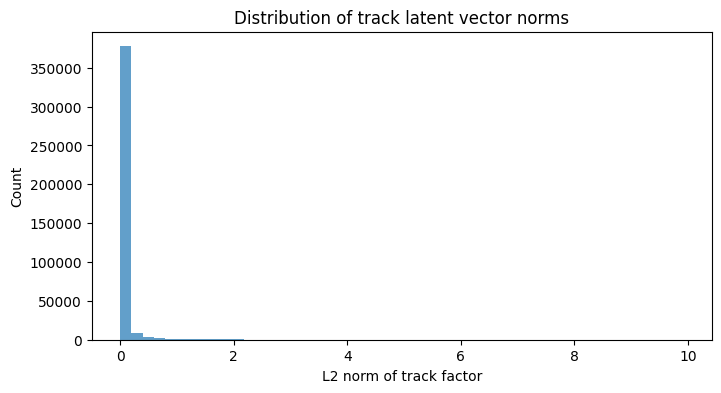

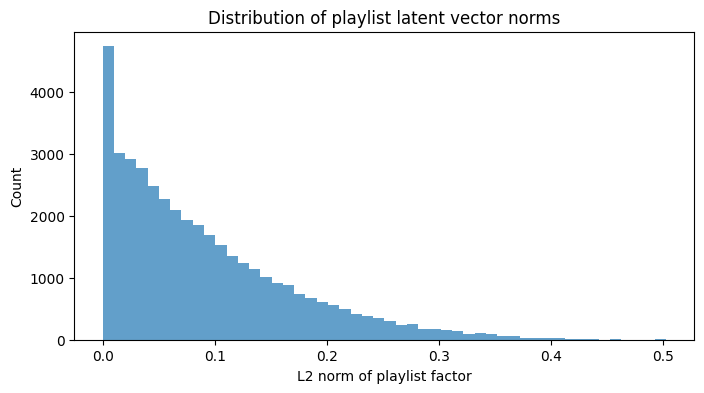

In [46]:
import numpy as np
import matplotlib.pyplot as plt

user_factors = als_model.user_factors      # tracks
item_factors = als_model.item_factors      # playlists

print("Track factors shape:", user_factors.shape)
print("Playlist factors shape:", item_factors.shape)

# Norms
track_norms = np.linalg.norm(user_factors, axis=1)
pl_norms = np.linalg.norm(item_factors, axis=1)

print("Track factor norms: mean", track_norms.mean(), "std", track_norms.std())
print("Playlist factor norms: mean", pl_norms.mean(), "std", pl_norms.std())

plt.figure(figsize=(8,4))
plt.hist(track_norms, bins=50, alpha=0.7)
plt.xlabel("L2 norm of track factor")
plt.ylabel("Count")
plt.title("Distribution of track latent vector norms")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(pl_norms, bins=50, alpha=0.7)
plt.xlabel("L2 norm of playlist factor")
plt.ylabel("Count")
plt.title("Distribution of playlist latent vector norms")
plt.show()


Running t-SNE on 5000 tracks...


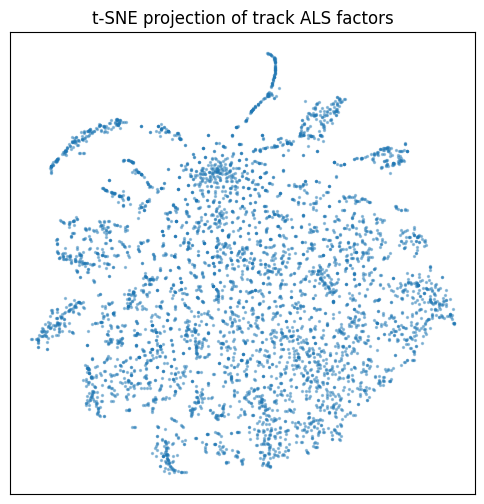

In [ ]:
from sklearn.manifold import TSNE

N_TSNE = 5000  # sample some tracks/playlists for plotting

idx_sample = np.random.choice(user_factors.shape[0], size=N_TSNE, replace=False)
X_tsne_input = user_factors[idx_sample]

print("Running t-SNE on", X_tsne_input.shape[0], "tracks...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=500,
    metric="euclidean",
    random_state=42,
    init="random",
)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=2, alpha=0.4)
plt.title("t-SNE projection of track ALS factors")
plt.xticks([]); plt.yticks([])
plt.show()


Running t-SNE on 20000 tracks...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='random', learning_rate=600,
     n_iter=1000, n_jobs=-1, perplexity=40, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 120 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.09 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 4.67 seconds
===> Running optimization with exaggeration=12.00, lr=600.00 for 250 iterations...
Iteration   50, KL divergence 5.8224, 50 iterations in 1.9205 sec
Iteration  100, KL divergence 5.1591, 50 iterations in 1.9363 sec
Iteration  150, KL divergence 5.1971, 50 iterations in 2.5507 sec
Iteration  200, KL divergence 5.1905, 50 iterations in 2.4559 sec
Iteration  250, KL divergence 5.1859, 50 iterations in 2.4328 sec
   --> Time elapsed: 11.30 seconds
===> Running

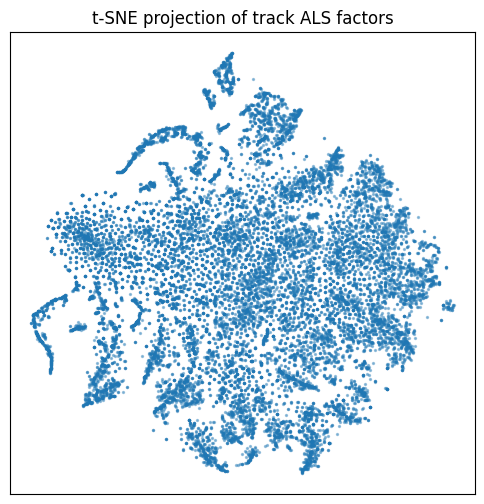

In [67]:
from openTSNE import TSNE
from tqdm import tqdm

print("Running t-SNE on", X_tsne_input.shape[0], "tracks...")

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=600,
    n_iter=1000,
    metric="euclidean",
    random_state=42,
    initialization="random",
    verbose=True,
    n_jobs=-1,
)

X_tsne = tsne.fit(X_tsne_input)

# That's it! The progress will print automatically
# Then continue with your plotting:
plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=2, alpha=0.4)
plt.title("t-SNE projection of track ALS factors")
plt.xticks([]); plt.yticks([])
plt.show()

In [48]:
import pandas as pd
import numpy as np

# Simple lookup table for names (one row per track_id)
meta_simple = (
    track_meta[["track_id", "track_name", "artist_name", "album_name"]]
    .drop_duplicates(subset=["track_id"])
    .reset_index(drop=True)
)

meta_simple.head()


,track_id,track_name,artist_name,album_name
0,0000uJA4xCdxThagdLkkLR,Heart As Cold As Stone,Cherryholmes,Cherryholmes
1,00039MgrmLoIzSpuYKurn9,Thas What I Do,Zach Farlow,The Great Escape 2
2,0005w1bMJ7QAMl6DY98oxa,"Sonata in G Major, BuxWV 271: Allegro -",Dietrich Buxtehude,"Chamber Music: London Baroque - Rosenmuller, J..."
3,0007AYhg2UQbEm88mxu7js,Mandarin Oranges Part 2,Little Simz,E.D.G.E
4,000CTwOSsvRs0bgXlwB64e,Shady World,Celly Cel,The Lost Tapes


In [49]:
def find_tracks_by_name(query, n=25):
    """
    Fuzzy search for tracks whose name contains `query` (case-insensitive).
    Returns a small DataFrame of candidates to pick from.
    """
    mask = meta_simple["track_name"].str.contains(query, case=False, na=False)
    candidates = meta_simple[mask].head(n).reset_index(drop=True)
    return candidates


In [50]:
track_factors = als_model.user_factors  # rows correspond to internal track indices

def recommend_similar_tracks_by_id_als(seed_track_id, top_k=15):
    """
    Use ALS *track* factors as an item–item model:
    - take the latent vector for `seed_track_id`
    - score all other tracks by dot product
    - return top_k with metadata
    """
    if seed_track_id not in tid_to_idx:
        raise ValueError(f"track_id {seed_track_id} not in ALS training set")

    seed_idx = tid_to_idx[seed_track_id]
    seed_vec = track_factors[seed_idx]            # (factors,)
    
    # Scores for all tracks: similarity in ALS latent space
    scores = track_factors @ seed_vec            # (n_tracks,)
    
    # Don't recommend the seed itself
    scores[seed_idx] = -np.inf
    
    # Top-K indices
    top_idx = np.argpartition(-scores, top_k)[:top_k]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    
    top_scores = scores[top_idx]
    top_tids   = idx_to_tid[top_idx]

    rec_df = pd.DataFrame({
        "track_id": top_tids,
        "als_similarity": top_scores,
    })
    rec_df = rec_df.merge(meta_simple, on="track_id", how="left")
    return rec_df


In [51]:
def recommend_by_name_als(query, candidate_index=0, top_k=15):
    """
    1. Search by track name (LIKE '%query%')
    2. Show candidates so you can see what you're choosing
    3. Pick candidate_index (0-based)
    4. Return ALS-based similar tracks (with metadata + similarity score)
    """
    candidates = find_tracks_by_name(query, n=20)
    if candidates.empty:
        print(f"No matches for query: {query}")
        return None
    
    print("Search results:")
    display(candidates)
    
    if candidate_index >= len(candidates):
        raise IndexError(f"candidate_index {candidate_index} out of range (got {len(candidates)} matches)")
    
    seed_row = candidates.iloc[candidate_index]
    seed_tid = seed_row["track_id"]
    
    print("\nChosen seed track:")
    display(seed_row.to_frame().T)
    
    recs = recommend_similar_tracks_by_id_als(seed_tid, top_k=top_k)
    
    print("\nALS similar-track recommendations:")
    display(
        recs[[
            "track_name",
            "artist_name",
            "album_name",
            "als_similarity",
        ]]
    )
    
    return recs


In [52]:
# Example: recommend based on "ocean eyes"
recs = recommend_by_name_als("gold digger", candidate_index=10, top_k=15)


Search results:


,track_id,track_name,artist_name,album_name
0,0KYIiOHyUc4Nas7vJdIC8p,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Music of K...
1,0SkkacQkMZRhfslMkogDTf,Gold Digger - (Karaoke Version) [In The Style ...,Karaoke Jukebox Heroes,Karaoke: #1 Hits 2000-2009 Vol. 4
2,14RcvIro4H3ZzLMOVUopij,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Songs from...
3,1M1DkiVCJ7KURGMkSXrZKh,Gold Digger,EPMD,Business As Usual
4,2xXvsn8TS0vChWiOYTjykJ,Gold Digger,Dash of Honey,Material World
5,49iK9E5CzpPPfM2KmPGZOU,Gold Digger (1962 Single Version),Jimmy Cliff,The Ska Singles 1961 - 1962
6,542PDuGAg1nAFCpdTHEstn,Gold Digger - Power Remix,Indy Q,Best of Shape - Walking Workout
7,59zeA8pvzq0ZHFR9asFR6N,Gold Digger,Rockabye Baby!,Lullaby Renditions of Kanye West
8,5LfqRu6S4CNEQMhBRydbW2,Gold Digger,Lefree,Gold Digger
9,5M1cPBSlmpztMxaTSv1Cdx,Gold Digger - Mornay Mix,Jackie Chandiru,Gold Digger



Chosen seed track:


,track_id,track_name,artist_name,album_name
10,5XJJdNPkwmbUwE79gv0NxK,Gold Digger,Kanye West,Late Registration



ALS similar-track recommendations:


,track_name,artist_name,album_name,als_similarity
0,Stronger,Kanye West,Graduation,34.896111
1,Ni**as In Paris,JAY Z,Top Five,29.920605
2,Yeah!,Usher,Confessions,28.991096
3,Ignition - Remix,R. Kelly,Chocolate Factory,27.778900
4,In Da Club,50 Cent,Get Rich Or Die Tryin',25.695005
5,Hey Ya! - Radio Mix / Club Mix,OutKast,Speakerboxxx/The Love Below,23.882414
6,POWER,Kanye West,My Beautiful Dark Twisted Fantasy,23.198183
7,Get Low - Street,Lil Jon & The East Side Boyz,Kings Of Crunk,21.889462
8,Drop It Like It's Hot,Snoop Dogg,R&G (Rhythm & Gangsta): The Masterpiece,21.466194
9,Hot In Herre,Nelly,Nellyville,21.016460


In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualise_als_neighbourhood(
    query,
    candidate_index=0,
    top_k=30,
    n_background=1500,
    random_state=42,
):
    """
    Visualise where a seed song and its ALS neighbours live in the ALS latent space.
    """
    # 1) Find seed track by name
    candidates = find_tracks_by_name(query, n=20)
    if candidates.empty:
        print(f"No matches for query: {query}")
        return None
    
    print("Search results:")
    display(candidates)
    
    if candidate_index >= len(candidates):
        raise IndexError(
            f"candidate_index {candidate_index} out of range "
            f"(got {len(candidates)} matches)"
        )
    
    seed_row = candidates.iloc[candidate_index]
    seed_tid = seed_row["track_id"]
    
    print("\nChosen seed track:")
    display(seed_row.to_frame().T)
    
    # 2) ALS neighbours for this seed
    recs = recommend_similar_tracks_by_id_als(seed_tid, top_k=top_k)
    
    # 3) Build index sets
    n_tracks, n_factors = track_factors.shape
    rng = np.random.default_rng(random_state)
    
    seed_idx = tid_to_idx[seed_tid]
    neigh_tids = recs["track_id"].values
    neigh_idx = np.array([tid_to_idx[tid] for tid in neigh_tids])
    
    # background = random other tracks not in seed or neighbours
    forbidden = set([seed_idx]) | set(neigh_idx.tolist())
    all_idx = np.arange(n_tracks)
    mask_bg = np.array([i not in forbidden for i in all_idx])
    bg_candidates = all_idx[mask_bg]
    
    n_bg = min(n_background, len(bg_candidates))
    bg_idx = rng.choice(bg_candidates, size=n_bg, replace=False)
    
    # 4) Stack the factors for PCA
    all_plot_idx = np.concatenate([[seed_idx], neigh_idx, bg_idx])
    X = track_factors[all_plot_idx]   # (1 + top_k + n_bg, n_factors)
    
    # PCA to 2D
    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)
    
    # Split back out
    seed_point     = X_2d[0:1]
    neigh_points   = X_2d[1:1+len(neigh_idx)]
    bg_points      = X_2d[1+len(neigh_idx):]
    
    # 5) Plot
    plt.figure(figsize=(8, 6))
    
    plt.scatter(
        bg_points[:, 0],
        bg_points[:, 1],
        s=5,
        alpha=0.2,
        label="Background tracks",
    )
    
    plt.scatter(
        neigh_points[:, 0],
        neigh_points[:, 1],
        s=30,
        alpha=0.8,
        label="ALS neighbours",
    )
    
    plt.scatter(
        seed_point[:, 0],
        seed_point[:, 1],
        s=120,
        marker="*",
        edgecolor="black",
        linewidth=1.0,
        label="Seed track",
    )
    
    plt.title(f"ALS latent space (PCA 2D) – neighbourhood of '{seed_row['track_name']}'")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        "seed": seed_row,
        "recs": recs,
        "indices": {
            "seed_idx": seed_idx,
            "neigh_idx": neigh_idx,
            "bg_idx": bg_idx,
        },
        "pca": pca,
    }


Search results:


,track_id,track_name,artist_name,album_name
0,0M8AdXqLJKGGXfYgabEX2C,Hotel Room Service - Dj Dizzy Hotel Motel Remix,DJ Dizzy,"Club Traxxx Summer Slammin', Vol. 3"
1,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution
2,4lxE7lFNmTmL7SVGAzxDnw,Hotel Room Service Remix,Pitbull,Pitbull Starring In Rebelution



Chosen seed track:


,track_id,track_name,artist_name,album_name
1,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution


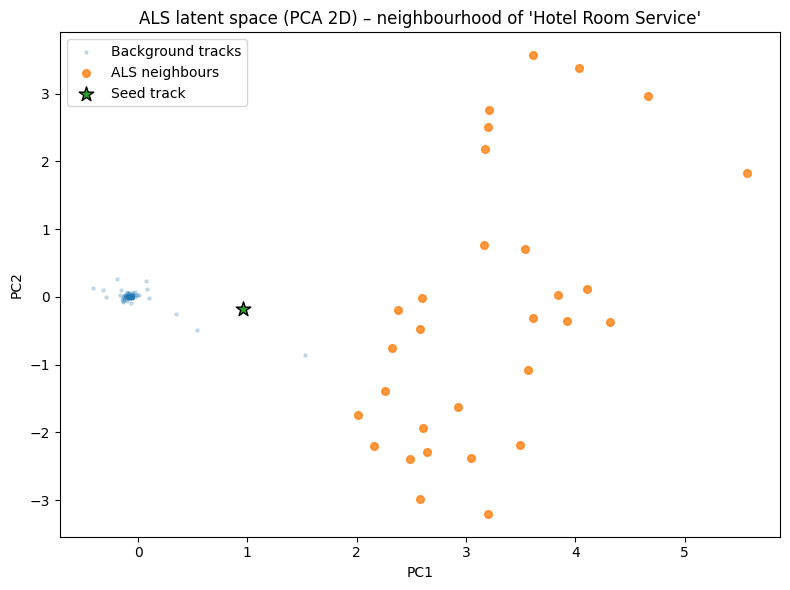

In [54]:
_ = visualise_als_neighbourhood("hotel room service", candidate_index=1, top_k=30)


Search results:


,track_id,track_name,artist_name,album_name
0,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
1,2olNHiPoHP5SG6w2b84QEd,Ocean Eyes,The Copper Children,What We Are
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
3,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
4,475HVfoKML70xddRf06X4h,Ocean Eyes,Kool&Klean,Volume I
5,4BCGi8gpTqqN8RzyykvLoF,Ocean Eyes,Dylan Wright,Ocean Eyes - Single
6,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
7,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes
8,6q2NdteQRnT3FdRMiZm1Pn,Blue Ocean Eyes (feat. Sevar),Vugarixx,Blue Ocean Eyes (feat. Sevar)



Chosen seed track:


,track_id,track_name,artist_name,album_name
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me


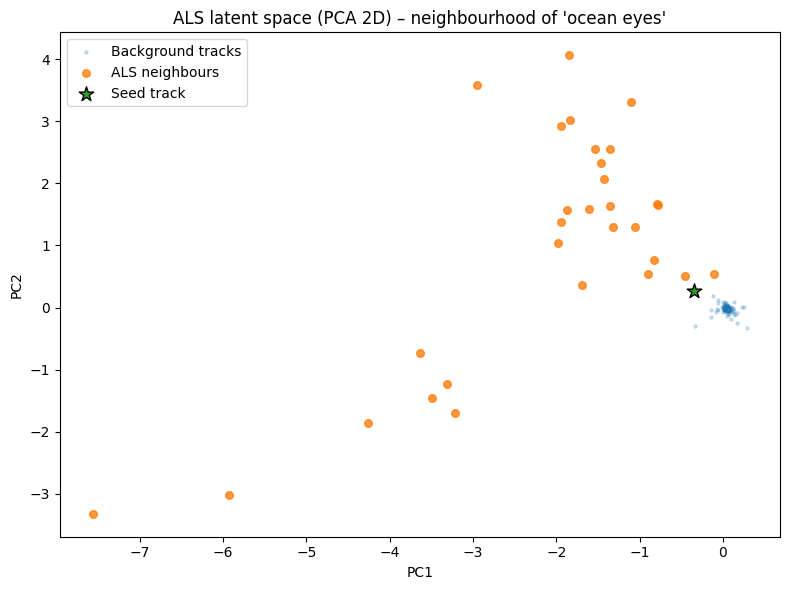

In [55]:
_ = visualise_als_neighbourhood("ocean eyes", candidate_index=2, top_k=30)


In [56]:
def visualise_two_als_neighbourhoods(
    query1, cand_idx1,
    query2, cand_idx2,
    top_k=30,
    n_background=2000,
    random_state=42,
):
    """
    Compare two seeds + their ALS neighbours in the same 2D latent space plot.
    """
    # 1) Resolve both seeds
    cand1 = find_tracks_by_name(query1, n=20)
    cand2 = find_tracks_by_name(query2, n=20)
    
    if cand1.empty or cand2.empty:
        print("One of the queries returned no results.")
        return None
    
    if cand_idx1 >= len(cand1) or cand_idx2 >= len(cand2):
        raise IndexError("candidate_index out of range for one of the queries.")
    
    seed1 = cand1.iloc[cand_idx1]
    seed2 = cand2.iloc[cand_idx2]
    
    seed1_tid = seed1["track_id"]
    seed2_tid = seed2["track_id"]
    
    print("Seed 1:")
    display(seed1.to_frame().T)
    print("\nSeed 2:")
    display(seed2.to_frame().T)
    
    # 2) ALS neighbours for both
    recs1 = recommend_similar_tracks_by_id_als(seed1_tid, top_k=top_k)
    recs2 = recommend_similar_tracks_by_id_als(seed2_tid, top_k=top_k)
    
    # 3) Indices
    n_tracks, n_factors = track_factors.shape
    rng = np.random.default_rng(random_state)
    
    s1_idx = tid_to_idx[seed1_tid]
    s2_idx = tid_to_idx[seed2_tid]
    
    neigh1_idx = np.array([tid_to_idx[t] for t in recs1["track_id"].values])
    neigh2_idx = np.array([tid_to_idx[t] for t in recs2["track_id"].values])
    
    forbidden = set([s1_idx, s2_idx]) | set(neigh1_idx.tolist()) | set(neigh2_idx.tolist())
    all_idx = np.arange(n_tracks)
    bg_candidates = all_idx[[i not in forbidden for i in all_idx]]
    
    n_bg = min(n_background, len(bg_candidates))
    bg_idx = rng.choice(bg_candidates, size=n_bg, replace=False)
    
    # 4) Stack for PCA
    all_plot_idx = np.concatenate([[s1_idx, s2_idx], neigh1_idx, neigh2_idx, bg_idx])
    X = track_factors[all_plot_idx]
    
    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)
    
    # Split back out
    s1_point = X_2d[0:1]
    s2_point = X_2d[1:2]
    start_n1 = 2
    end_n1   = 2 + len(neigh1_idx)
    neigh1_points = X_2d[start_n1:end_n1]
    
    start_n2 = end_n1
    end_n2   = end_n1 + len(neigh2_idx)
    neigh2_points = X_2d[start_n2:end_n2]
    
    bg_points = X_2d[end_n2:]
    
    # 5) Plot
    plt.figure(figsize=(9, 7))
    
    plt.scatter(
        bg_points[:, 0], bg_points[:, 1],
        s=5, alpha=0.15, label="Background tracks", color="lightgrey"
    )
    
    plt.scatter(
        neigh1_points[:, 0], neigh1_points[:, 1],
        s=30, alpha=0.8, label=f"Neighbours of '{seed1['track_name']}'"
    )
    plt.scatter(
        neigh2_points[:, 0], neigh2_points[:, 1],
        s=30, alpha=0.8, label=f"Neighbours of '{seed2['track_name']}'"
    )
    
    plt.scatter(
        s1_point[:, 0], s1_point[:, 1],
        s=140, marker="*", edgecolor="black", linewidth=1.0,
        label=f"Seed 1: {seed1['track_name']}"
    )
    plt.scatter(
        s2_point[:, 0], s2_point[:, 1],
        s=140, marker="*", edgecolor="black", linewidth=1.0,
        label=f"Seed 2: {seed2['track_name']}"
    )
    
    plt.title("ALS latent space – two neighbourhoods compared (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        "seed1": seed1,
        "seed2": seed2,
        "recs1": recs1,
        "recs2": recs2,
        "pca": pca,
    }


Seed 1:


,track_id,track_name,artist_name,album_name
1,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution



Seed 2:


,track_id,track_name,artist_name,album_name
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me


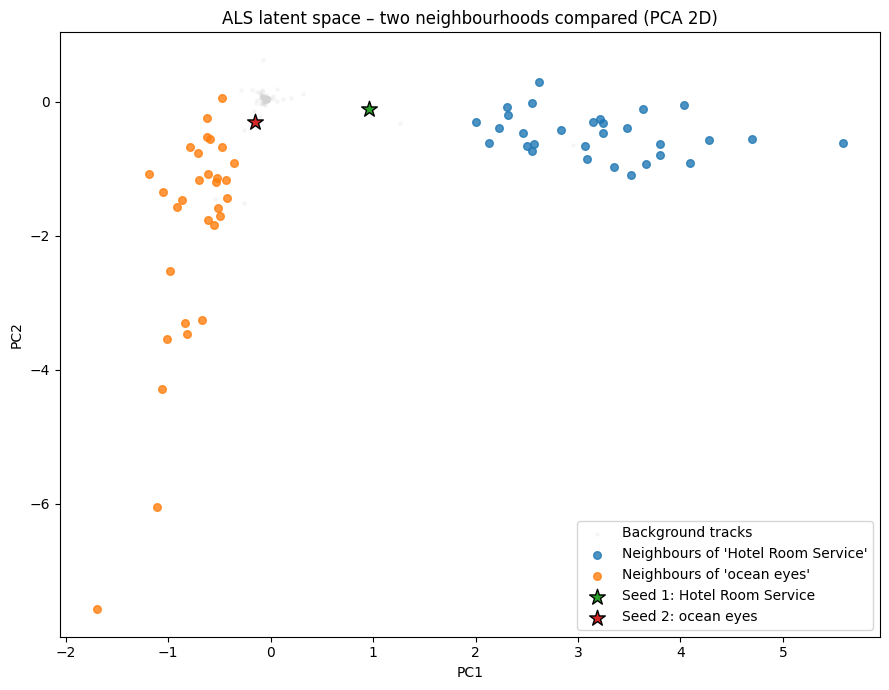

In [57]:
_ = visualise_two_als_neighbourhoods(
    "hotel room service", 1,   # Pitbull
    "ocean eyes",        2,   # Billie Eilish
    top_k=30,
)


In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualise_multi_als_neighbourhoods(
    seed_specs,
    top_k=30,
    n_background=3000,
    random_state=42,
):
    """
    Visualise multiple seeds and their ALS neighbours in the same 2D latent space.

    Parameters
    ----------
    seed_specs : list of dicts
        Each dict should have:
          - "query": str               (song name search term)
          - "candidate_index": int     (which search result to pick)
          - "label": optional str      (override label for legend)
    top_k : int
        Number of ALS neighbours per seed.
    n_background : int
        Number of random background tracks for context.
    random_state : int
        RNG seed for reproducible background sampling.
    """
    rng = np.random.default_rng(random_state)

    n_tracks, n_factors = track_factors.shape
    print(f"[INFO] ALS track_factors shape: {track_factors.shape}")

    seed_infos = []      # list of dicts with seed meta & indices
    neighbour_infos = [] # list of dicts with neighbours indices & recs

    # ----- 1. Resolve seeds + ALS neighbours -----
    for i, spec in enumerate(seed_specs):
        query = spec["query"]
        cand_idx = spec.get("candidate_index", 0)
        label = spec.get("label", query)

        print(f"\n[SEED {i}] Query: {query!r}")
        candidates = find_tracks_by_name(query, n=20)
        if candidates.empty:
            print(f"  -> No matches found, skipping this seed.")
            continue

        print("Search results:")
        display(candidates)

        if cand_idx >= len(candidates):
            print(f"  -> candidate_index={cand_idx} out of range "
                  f"(got {len(candidates)} matches), skipping.")
            continue

        seed_row = candidates.iloc[cand_idx]
        seed_tid = seed_row["track_id"]
        seed_idx = tid_to_idx.get(seed_tid)

        if seed_idx is None:
            print(f"  -> seed track_id {seed_tid} not in ALS index, skipping.")
            continue

        print("\nChosen seed track:")
        display(seed_row.to_frame().T)

        # ALS neighbours
        recs = recommend_similar_tracks_by_id_als(seed_tid, top_k=top_k)
        neigh_tids = recs["track_id"].values
        neigh_idx = np.array([tid_to_idx[tid] for tid in neigh_tids])

        seed_infos.append({
            "label": label,
            "query": query,
            "seed_row": seed_row,
            "seed_tid": seed_tid,
            "seed_idx": seed_idx,
        })
        neighbour_infos.append({
            "label": label,
            "indices": neigh_idx,
            "recs": recs,
        })

    if not seed_infos:
        print("No valid seeds found, nothing to plot.")
        return None

    # ----- 2. Build index sets for PCA -----
    seed_indices = np.array([s["seed_idx"] for s in seed_infos], dtype=int)

    neigh_indices_all = []
    for info in neighbour_infos:
        neigh_indices_all.extend(info["indices"].tolist())
    neigh_indices_all = np.array(sorted(set(neigh_indices_all)), dtype=int)

    # Background = tracks not in seeds or neighbours
    forbidden = set(seed_indices.tolist()) | set(neigh_indices_all.tolist())
    all_idx = np.arange(n_tracks, dtype=int)
    mask_bg = np.array([i not in forbidden for i in all_idx])
    bg_candidates = all_idx[mask_bg]

    if len(bg_candidates) == 0:
        print("[WARN] No background candidates available.")
        bg_idx = np.array([], dtype=int)
    else:
        n_bg = min(n_background, len(bg_candidates))
        bg_idx = rng.choice(bg_candidates, size=n_bg, replace=False)

    print(f"\n[INFO] Seeds: {len(seed_indices)}, "
          f"unique neighbours: {len(neigh_indices_all)}, "
          f"background: {len(bg_idx)}")

    # ----- 3. Stack factors & run PCA -> 2D -----
    all_plot_idx = np.concatenate([seed_indices, neigh_indices_all, bg_idx])
    X = track_factors[all_plot_idx]

    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)

    # Split back into slices
    n_seeds = len(seed_indices)
    n_neigh = len(neigh_indices_all)
    n_bg = len(bg_idx)

    seeds_2d = X_2d[:n_seeds]
    neigh_2d = X_2d[n_seeds:n_seeds + n_neigh]
    bg_2d = X_2d[n_seeds + n_neigh:]

    # Map global neighbour indices back to each seed’s subset
    # for separate colours.
    idx_to_pos_in_neigh_all = {idx: pos for pos, idx in enumerate(neigh_indices_all)}

    # ----- 4. Plot -----
    plt.figure(figsize=(12, 8))

    # Background
    if n_bg > 0:
        plt.scatter(
            bg_2d[:, 0], bg_2d[:, 1],
            s=5, alpha=0.25, color="black", label="Background tracks"
        )

    # Colormap for seeds
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, n_seeds)))

    # Neighbour clouds
    for i, (seed_info, neigh_info) in enumerate(zip(seed_infos, neighbour_infos)):
        label = seed_info["label"]
        c = colors[i]

        local_neigh_idx = neigh_info["indices"]
        local_positions = [idx_to_pos_in_neigh_all[idx] for idx in local_neigh_idx]
        local_points = neigh_2d[local_positions]

        plt.scatter(
            local_points[:, 0], local_points[:, 1],
            s=30, alpha=0.8, color=c,
            label=f"Neighbours of '{label}'"
        )

    # Seed points (stars)
    for i, seed_info in enumerate(seed_infos):
        label = seed_info["label"]
        c = colors[i]
        pt = seeds_2d[i:i+1]

        plt.scatter(
            pt[:, 0], pt[:, 1],
            s=150, marker="*", edgecolor="black", linewidth=1.0,
            color=c, label=f"Seed: {label}"
        )

    plt.title("ALS latent space (PCA 2D) – multiple seed neighbourhoods")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return {
        "seeds": seed_infos,
        "neighbours": neighbour_infos,
        "bg_indices": bg_idx,
        "pca": pca,
    }


[INFO] ALS track_factors shape: (397514, 64)

[SEED 0] Query: 'hotel room service'
Search results:


,track_id,track_name,artist_name,album_name
0,0M8AdXqLJKGGXfYgabEX2C,Hotel Room Service - Dj Dizzy Hotel Motel Remix,DJ Dizzy,"Club Traxxx Summer Slammin', Vol. 3"
1,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution
2,4lxE7lFNmTmL7SVGAzxDnw,Hotel Room Service Remix,Pitbull,Pitbull Starring In Rebelution



Chosen seed track:


,track_id,track_name,artist_name,album_name
1,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution



[SEED 1] Query: 'ocean eyes'
Search results:


,track_id,track_name,artist_name,album_name
0,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
1,2olNHiPoHP5SG6w2b84QEd,Ocean Eyes,The Copper Children,What We Are
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
3,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
4,475HVfoKML70xddRf06X4h,Ocean Eyes,Kool&Klean,Volume I
5,4BCGi8gpTqqN8RzyykvLoF,Ocean Eyes,Dylan Wright,Ocean Eyes - Single
6,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
7,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes
8,6q2NdteQRnT3FdRMiZm1Pn,Blue Ocean Eyes (feat. Sevar),Vugarixx,Blue Ocean Eyes (feat. Sevar)



Chosen seed track:


,track_id,track_name,artist_name,album_name
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me



[SEED 2] Query: 'Paranoid Android'
Search results:


,track_id,track_name,artist_name,album_name
0,1cKDrnUwGE7vejktK58PTI,Paranoid Android,El Ten Eleven,These Promises Are Being Videotaped
1,2nTsKOXIVGDf2iPeVQO2Gm,Paranoid Android,Radiohead,OK Computer
2,2o8QYkTODvc2JhZWatfnRG,Paranoid Android,Sia,Exit Music: Songs With Radio Heads
3,2sowiwuhxt4nLIWP6vWJOa,Paranoid Android,Brad Mehldau,Largo
4,2x4FXtLjsOaWRmaHgnaUzl,Paranoid Android (Made Famous by Radiohead),Piano Tribute Players,35 Piano Rock Classics
5,5DpcCycOihrtlk85DJlBCt,Paranoid Android,Gareth Pearson,Urban Echoes Vol. 1
6,5PkNuAZ2xHnuNHIVvonkNv,Paranoid Android,Easy Star All-Stars,Radiodread



Chosen seed track:


,track_id,track_name,artist_name,album_name
1,2nTsKOXIVGDf2iPeVQO2Gm,Paranoid Android,Radiohead,OK Computer



[SEED 3] Query: 'All I want for Christmas is You'
Search results:


,track_id,track_name,artist_name,album_name
0,01CAl93919STkcUjhduu9D,All I Want for Christmas Is You,Jessie James Decker,This Christmas
1,0EVVUSgiXvwiLY0hHXG7GG,All I Want For Christmas Is You,Whitney Duncan,All I Want For Christmas Is You
2,0EweH7NNqxwaS4fCJ262WQ,All I Want For Christmas Is You - So So Def Re...,Mariah Carey,Greatest Hits
3,0GeeK6IhQpZnLOoa79oxIU,All I Want For Christmas Is You,Against The Current,All I Want For Christmas Is You
4,0HRvIqJxpkQOrqDsnslofN,All I Want for Christmas Is You,Batfoot!,Punk Rock Christmas
5,0OiJrQ6mW70e2d2iNKoMX5,All I Want for Christmas Is You - House Remix,Pierre Cardin,Christmas Remixes Vol. 1
6,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,Mariah Carey,Merry Christmas
7,0lgg2Kwj50tkR72hvcgGCB,All I Want For Christmas Is You,Celtic Thunder,Celtic Thunder Christmas
8,0u0Yuu2O6rgXLqr7KBMgzK,All I Want for Christmas Is You,The Covington Catholic Chamber Choir,I'll Be Home
9,0xPaZrF25ltzvz1a2Pm5DQ,All I Want For Christmas Is You,Michael Bublé,Christmas



Chosen seed track:


,track_id,track_name,artist_name,album_name
6,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,Mariah Carey,Merry Christmas



[SEED 4] Query: 'gold digger'
Search results:


,track_id,track_name,artist_name,album_name
0,0KYIiOHyUc4Nas7vJdIC8p,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Music of K...
1,0SkkacQkMZRhfslMkogDTf,Gold Digger - (Karaoke Version) [In The Style ...,Karaoke Jukebox Heroes,Karaoke: #1 Hits 2000-2009 Vol. 4
2,14RcvIro4H3ZzLMOVUopij,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Songs from...
3,1M1DkiVCJ7KURGMkSXrZKh,Gold Digger,EPMD,Business As Usual
4,2xXvsn8TS0vChWiOYTjykJ,Gold Digger,Dash of Honey,Material World
5,49iK9E5CzpPPfM2KmPGZOU,Gold Digger (1962 Single Version),Jimmy Cliff,The Ska Singles 1961 - 1962
6,542PDuGAg1nAFCpdTHEstn,Gold Digger - Power Remix,Indy Q,Best of Shape - Walking Workout
7,59zeA8pvzq0ZHFR9asFR6N,Gold Digger,Rockabye Baby!,Lullaby Renditions of Kanye West
8,5LfqRu6S4CNEQMhBRydbW2,Gold Digger,Lefree,Gold Digger
9,5M1cPBSlmpztMxaTSv1Cdx,Gold Digger - Mornay Mix,Jackie Chandiru,Gold Digger



Chosen seed track:


,track_id,track_name,artist_name,album_name
10,5XJJdNPkwmbUwE79gv0NxK,Gold Digger,Kanye West,Late Registration



[INFO] Seeds: 5, unique neighbours: 137, background: 300000


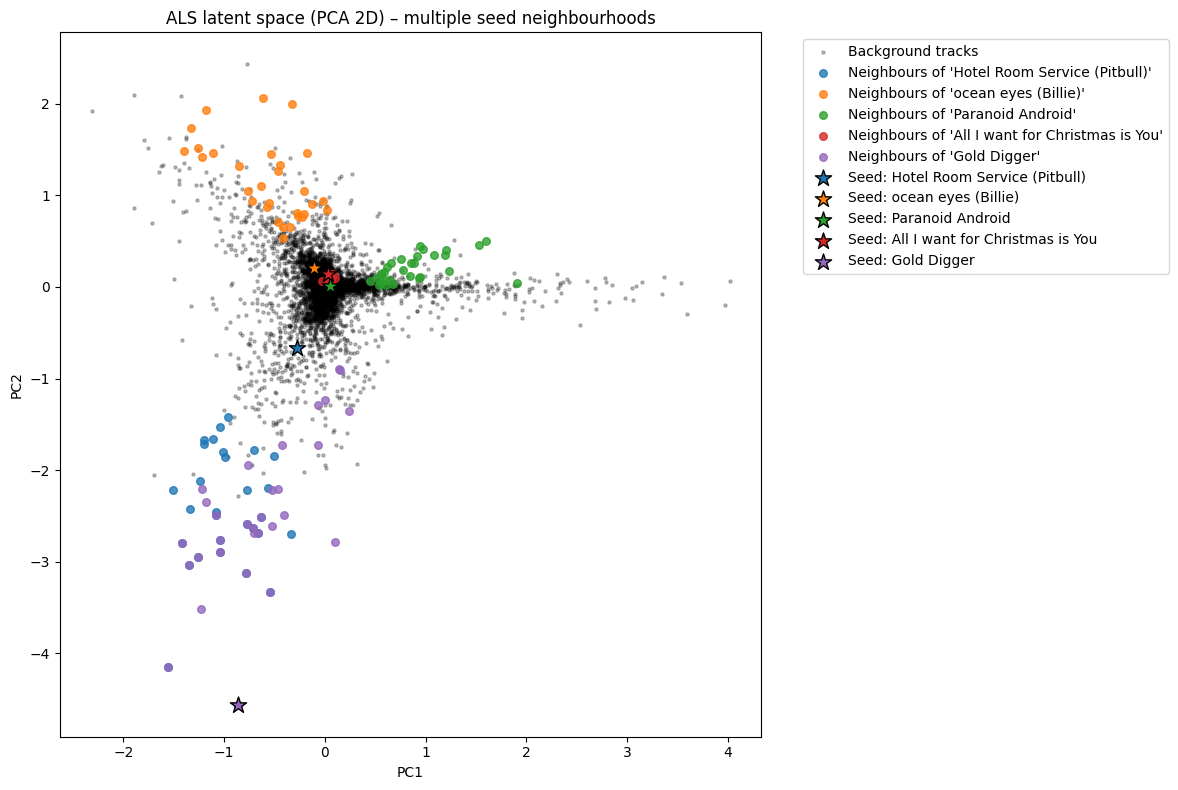

In [60]:
seed_specs = [
    {
        "query": "hotel room service",
        "candidate_index": 1,   # Pitbull
        "label": "Hotel Room Service (Pitbull)",
    },
    {
        "query": "ocean eyes",
        "candidate_index": 2,   # Billie Eilish
        "label": "ocean eyes (Billie)",
    },
    {
        "query": "Paranoid Android",
        "candidate_index": 1,
        "label": "Paranoid Android",
    },
    {
        "query": "All I want for Christmas is You",
        "candidate_index": 6,
        "label": "All I want for Christmas is You",
    },
    {
        "query": "gold digger",
        "candidate_index": 10,
        "label": "Gold Digger",
    },
]

_ = visualise_multi_als_neighbourhoods(
    seed_specs,
    top_k=30,
    n_background=300000,
)
